In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# def f(x, y):
#     "Objective function"
#     return ((x/100)-3.14)**2 + ((y/100)-2.72)**2 + np.sin(3*(x/100)+1.41) + np.sin(4*(y/100)-1.73)

In [ ]:
def f(x, y):
    return np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

In [4]:
class Particle:
    def __init__(self, env, name, particles, X=np.array([1, 1]), target = [np.array([5,5]),-1], waypoint = np.array([8,8]), c1=0.1, c2=0.1, w=0.8, speed=0.015433, 
                 transRange=1.0, link_error_rate = 0.0):
        self.env = env
        self.name = name
        self.particles = particles  # List of all particles
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.transmission_range = transRange
        self.speed = speed # 0.015433 -> 3 knots
        self.stop_flag = False # when find the target stop
        self.targetFounded = False
        self.waypoint = waypoint
        self.link_error_rate = link_error_rate

        self.X = X
        self.target = target
        self.V = np.random.randn(2) * 0.1
        self.pbest_position = self.X.copy()
        self.pbest_fitness = f(self.X[0], self.X[1])

        self.nbest_position = self.X.copy()
        self.nbest_fitness = self.pbest_fitness

        self.positions = [self.X.copy()]

        self.process = env.process(self.run())

    def broadcast(self):
        """Broadcast nbest to other particles based on proximity."""
        for particle in self.particles:
            if particle != self:
                distance = np.linalg.norm(self.X - particle.X) # Euclidean distance
                if distance < self.transmission_range:  # Accoustic module Transmission range
                    particle.receive(self.nbest_position, self.nbest_fitness, self.targetFounded)
                    # if self.targetFounded:
                    #     particle.receive(self.target[0][0], self.target[0][1], self.targetFounded)
                    # else:
                    #     particle.receive(self.nbest_position, self.nbest_fitness, self.targetFounded)

    def receive(self, nbest_position, nbest_fitness, isTarget):
        """update the personal nbest"""
        if np.random.random(1)[0] >= self.link_error_rate: # If error, msg not reveived
            if nbest_fitness < self.nbest_fitness:
                self.nbest_position = nbest_position.copy()
                self.nbest_fitness = nbest_fitness
                self.targetFounded = isTarget
    
    def update(self):
        r1, r2 = np.random.rand(2)
        self.V = self.w * self.V + self.c1 * r1 * (self.pbest_position - self.X) + self.c2 * r2 * (self.nbest_position - self.X)
        self.waypoint = self.X + self.V

    def sensing(self):
        if not self.targetFounded:
            fitness = f(self.X[0], self.X[1])

            if fitness < self.pbest_fitness:
                self.pbest_position = self.X.copy()
                self.pbest_fitness = fitness

            if fitness < self.nbest_fitness:
                self.nbest_position = self.X.copy()
                self.nbest_fitness = fitness

    def move(self):
        if not self.stop_flag:
            if self.targetFounded:
                direction = self.nbest_position-self.X
            else:
                direction = self.waypoint-self.X
            self.X = self.X + self.speed * (direction / np.linalg.norm(direction))
            distance = np.linalg.norm(self.X - self.waypoint) # Euclidean distance
            if distance <= 3:  # Interaction threshold
                self.update()
                #print(self.name," Updated! ", self.V, " nbest_loc ", self.nbest_position, " nbest_fit ", self.nbest_fitness)

    def targetFound(self):
        if np.linalg.norm(self.X - self.target[0]) <= 1:
            self.stop_flag = True
            self.targetFounded = True
            self.nbest_position = self.target[0].copy()
            self.nbest_fitness = self.target[1]

    def run(self):
        i = 0
        while True:
            self.targetFound()
            self.sensing()
            self.move()
            if i%5 ==0:
                self.broadcast()  # broadcast nbest to neighbors
            if i%10 ==0:    
                self.positions.append(self.X.copy()) # take the records of position
            i = i + 1
            yield self.env.timeout(1)

In [5]:
def initialize_arc_particles(n_particles, radius):
    """Evenly distribute particles on an arc from 0 to pi/2."""
    particles_postions = []
    
    start_angle = (np.pi / 2)*(2/90)
    end_angle = (np.pi / 2)*(88/90)

    # Generate evenly spaced angles between 0 and pi/2
    angles = np.linspace(start_angle, end_angle, n_particles)

    # Create particles and assign positions based on the arc
    for i, theta in enumerate(angles):
        # Convert polar coordinates to Cartesian (x, y)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        position = np.array([x, y])  # Particle position on the arc
        particles_postions.append(position)
    
    return particles_postions

In [6]:
def check_termination_condition(env, particles, target_position, threshold=1.0, radius=0.05):
    while True:
        count_within_radius = sum(
            np.linalg.norm(p.X - target_position) <= radius for p in particles
        )
        if (count_within_radius >= threshold * len(particles)) or (env.now >= 2000):
            #print(f"Condition met at time {env.now}: {count_within_radius}/{len(particles)} particles near target.")
            return [env.event().succeed(),count_within_radius/len(particles)]  # Trigger the event to stop simulation
        yield env.timeout(1)

In [ ]:
def simulate_pso(n_particles = 20, radius = 500, tr=45, error_rate = 0.0):
    env = simpy.Environment()
    firstWaypoints = initialize_arc_particles(n_particles, radius)
    
    x, y = np.array(np.meshgrid(np.linspace(0, 10, 1000), np.linspace(0, 10, 1000)))
    z = f(x, y)
    x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]
    target_position = np.array([x_min, y_min])  # Define the target position
    target_fitness = f(x_min, y_min)

    particles = [Particle(env, f'Particle {i}', [], waypoint=firstWaypoints[i], transRange = tr, link_error_rate = error_rate) for i in range(n_particles)]
    for particle in particles:
        particle.particles = particles  # Give each particle the list of all particles
        particle.target = [target_position,target_fitness]
    
    termination_event = env.process(check_termination_condition(env, particles, target_position))
    env.run(until=termination_event)  # Simulation stops when termination_event is triggered

    count_within_radius = sum(
        np.linalg.norm(p.X - target_position) <= 0.05 for p in particles
    )

    global_best = min(particles, key=lambda p: p.pbest_fitness)
    return [p.positions for p in particles], global_best.pbest_position, global_best.pbest_fitness, env.now, count_within_radius/n_particles

In [10]:
positions, nbest, nbest_obj, running_time, AUVpercentage = simulate_pso(n_particles = 20, radius = 500, tr=45, error_rate = 0.0)

In [11]:
running_time, AUVpercentage

(2000, 0.0)

In [ ]:
# Multiple Transmission range
timeList = []
percentageList = []
for i in range(45,51):
    time = 0
    percentage = 0
    print("Current transmission range: ", i)
    for j in range(10):
        positions, nbest, nbest_obj, running_time, AUVpercentage = simulate_pso(n_particles = 20, radius = 500, tr=i)
        time = time + running_time
        percentage = AUVpercentage + percentage
    timeList.append(time/10)
    percentageList.append(percentage/10)

Current transmission range:  45
Current transmission range:  46
Current transmission range:  47
Current transmission range:  48
Current transmission range:  49
Current transmission range:  50


In [ ]:
# Multiple AUVs
timeList = []
percentageList = []
for i in range(10,51):
    time = 0
    percentage = 0
    print("Number of AUVs: ", i)
    for j in range(10):
        positions, nbest, nbest_obj, running_time, AUVpercentage = simulate_pso(n_particles = i, radius = 500, tr=1000.0)
        time = time + running_time
        percentage = AUVpercentage + percentage
    timeList.append(time/10)
    percentageList.append(percentage/10)

Number of AUVs:  10


KeyboardInterrupt: 

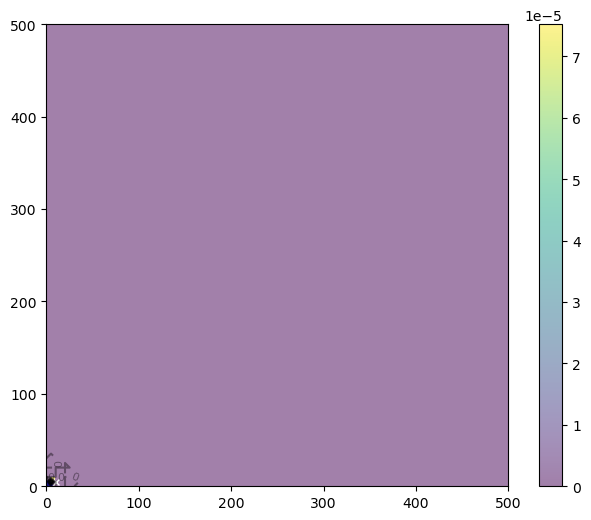

In [9]:
# Plotting and Animation
i =19
x, y = np.array(np.meshgrid(np.linspace(0, 500, 100), np.linspace(0, 500, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 500, 0, 500], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[i][0], positions[i][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

MovieWriter imagemagick unavailable; using Pillow instead.


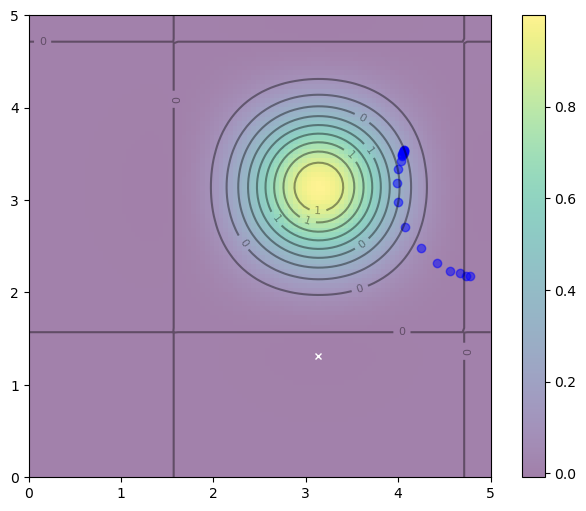

DPSO found best solution at f([3.17772054 1.24524301])=-0.008755650902337736


In [12]:
# Plotting and Animation
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

def animate(i):
    ax.clear()
    ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    for pos in positions:
        p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
    nbest_plot.set_offsets(nbest.reshape(1, -1))
    return ax, p_plot, nbest_plot

anim = FuncAnimation(fig, animate, frames=len(positions[0]), interval=500, blit=False, repeat=True)
anim.save("PSO-arc-r=5.gif", dpi=120, writer="imagemagick")
plt.show()

print("DPSO found best solution at f({})={}".format(nbest, nbest_obj))


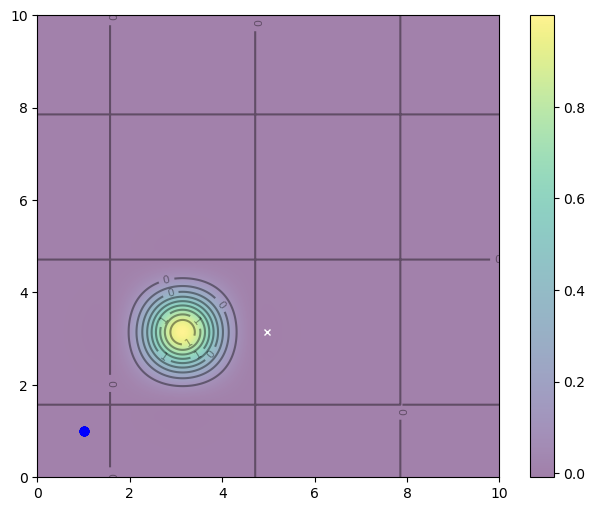

In [13]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, 10, 1000), np.linspace(0, 10, 1000)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 10, 0, 10], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

i = 0
ax.clear()
ax.imshow(z, extent=[0, 10, 0, 10], origin='lower', cmap='viridis', alpha=0.5)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
for pos in positions:
    p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
nbest_plot.set_offsets(nbest.reshape(1, -1))
plt.show()

In [3]:
# Currently not used
def levy_step(mu=1.5):
    """Generate a step length from a Levy distribution."""
    return np.random.pareto(mu)  # Using Pareto distribution for Levy flight